# **DATA TO PREDICT**

Multiple predictions are conducted using two types of databases (Chemdiv and Zinc).

## 1. DATABASE CHEMDIV

From this database, we obtained the "Cysteine targeted Covalent Library" which consists of 39,301 compounds with specific warheads designed to react with cysteine. THe objective of using this library is, by applying our trained model, to find possible compounds that exhibit significant interaction activity with cysteine. 

The features are the characteristics to describe data. The following features have been introduced with module RDKit to be constructed the dataframes for inputting into the ANN model:
* **Molecular weight (MW)**: The total sum of the atomic weights. 
* **LogP**: The lipophilicity or hydrophobicity of a molecule.
* **Number of hydrogen donors**: Number of hydrogen atoms in a molecule that are capable of forming hydrogen bonds as donors.
* **Number of hydrogen acceptors**: Number of sites in a molecule that can form hydrogen bonds as acceptors.
* **Topological Polar Surface Area (TPSA)**: Quantifies the surface area of a molecule that is polar or can potentially participate in hydrogen bonding.
* **Number of rotatable bonds**: Number of single bonds in a molecule that are not part of a rigid ring structure.
* **Ring counts**: Number of distinct ring structures within a molecule.
* **Heavy atom counts**: Number of non-hydrogen atoms in a molecule.
* **Fraction of sp3 hybridized carbons (CSP3)**: Fraction of carbons in a molecule that have sp3 hybridization.
* **Balaban J Index**: Information about the degree of branching in a molecule's structure.


In [2]:
#Import packages
import os
import os, requests

import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from rdkit import Chem
from rdkit.Chem import SDMolSupplier
from rdkit.Chem import Crippen, Descriptors



In [3]:
#Read a database sdf file. 

#from rdkit import Chem
#from rdkit.Chem import SDMolSupplier
#import pandas as pd

#import os, requests

path = '/Users/carlafeliu/Docs/Master/TFM/github'
sdffile='Download_SDF_Covalent_Cysteine_Library_39301.sdf'
localsdffile = os.path.join(path, sdffile)
if not os.path.exists(localsdffile):
    url = 'https://www.chemdiv.com/catalog/focused-and-targeted-libraries/cysteine-targeted-covalent-library/'+sdffile
    response = requests.get(url)
    with open(localsdffile, 'wb') as f:
        f.write(response.content)
        

database = Chem.SDMolSupplier('../../../Download_SDF_Covalent_Cysteine_Library_39301.sdf')



In [4]:
#Create a dataframe
#from rdkit import Chem
#from rdkit.Chem import Crippen, Descriptors
#from rdkit_forchemprop import features

def features(mol,data):
    #Extract properties using RDKit functions
    mol_name = mol.GetProp('Name')
    smiles = Chem.MolToSmiles(mol)
    formula = Chem.rdMolDescriptors.CalcMolFormula(mol)
    mw= Chem.rdMolDescriptors.CalcExactMolWt(mol)
    logp= Crippen.MolLogP(mol)
    num_hbd = Chem.rdMolDescriptors.CalcNumHBD(mol)
    num_hba = Chem.rdMolDescriptors.CalcNumHBA(mol)
    tpsa = Chem.rdMolDescriptors.CalcTPSA(mol)
    num_rb = Chem.rdMolDescriptors.CalcNumRotatableBonds(mol)
    ring_num = Chem.Descriptors.RingCount(mol)
    ha_num = Chem.Descriptors.HeavyAtomCount(mol)
    csp3 = Chem.Descriptors.FractionCSP3(mol)
    bji = Chem.Descriptors.BalabanJ(mol)

    #Append results in a data list
    data.append([smiles,mol_name,formula,mw,logp,num_hbd,num_hba,tpsa, num_rb, ring_num, ha_num, csp3, bji])
    return

data = [ ]

for mol in database:
    features(mol,data)

#We have a list with information. Creation of a Dataframe:
df_chemdiv= pd.DataFrame(data,columns=['SMILES','Name','Formula','MW','logP',"H-bond donor","H-bond acceptor","TPSA","Rotatable bonds", "Ring counts", "Heavy atoms counts", "Fraction CSP3", "Balaban J Index"])

Now we have a dataframe with Smiles of Covalent Cystein Library of Chemdiv and with features for each one. 

## 2. DATA ANALYSIS (DATA PREPARATION)

We perform a data analysis to check for missing data, as it could interfere with the predictions, and to understand the data we are working with.

In [5]:
#Print information about database
print("Information about first rows of dataset:")
print(df_chemdiv.head(10))
print("\n\n")

print("Dimensions of dataset:")
df_chemdiv.shape
print("\n\n")

print("General information about dataset:")
df_chemdiv.info()
print("\n\n")

print("Null values")
df_chemdiv.isna().sum().sort_values()
print("\n\n")

print("Description of the numerical variables:")
df_chemdiv.describe()

Information about first rows of dataset:
                                              SMILES  \
0                               C(#Cc1cccs1)c1ccccc1   
1            c1ccc(C2=NC(c3ccccc3)N3C2C3c2ccccc2)cc1   
2  C(#Cc1ccc(C2Nc3ccccc3C(c3ccccc3)(c3ccccc3)O2)o...   
3                         C(#Cc1csc2ccccc12)c1ccccc1   
4  C(#Cc1cccc(-c2nc3ccccc3nc2-c2cccc(C#Cc3ccc(Sc4...   
5  C(#Cc1cccc(-c2nc3ccccc3nc2-c2cccc(C#Cc3ccc(Oc4...   
6                              C(#Cc1ccccc1)c1ccccc1   
7            C(#Cc1cc(C#Cc2ccccc2)c2nonc2c1)c1ccccc1   
8                 C(#Cc1ccc2c(c1)sc1ccccc12)c1ccccc1   
9              C(#Cc1ccc2noc(-c3ccccc3)c2c1)c1ccccc1   

                                                Name     Formula          MW  \
0                    2-(2-phenyl-1-ethynyl)thiophene      C12H8S  184.034671   
1   2,4,6-triphenyl-1,3-diazabicyclo[3.1.0]hex-3-ene    C22H18N2  310.146999   
2  4,4-diphenyl-2-[5-(2-phenylethynyl)furan-2-yl]...   C32H23NO2  453.172879   
3               3-(2-p

,MW,logP,H-bond donor,H-bond acceptor,TPSA,Rotatable bonds,Ring counts,Heavy atoms counts,Fraction CSP3,Balaban J Index
count,39301.000000,39301.000000,39301.000000,39301.000000,39301.000000,39301.000000,39301.000000,39301.000000,39301.000000,39301.000000
mean,402.267185,3.871279,0.797410,5.126791,75.722257,5.578306,3.263836,27.736063,0.240146,1.878796
std,90.915555,1.440172,0.765759,1.872088,27.249668,2.555851,1.082915,6.337062,0.166282,0.387396
min,83.073499,-3.051000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.709908
25%,344.099477,2.981400,0.000000,4.000000,58.200000,4.000000,3.000000,24.000000,0.117647,1.634303
50%,412.109293,3.937120,1.000000,5.000000,75.170000,5.000000,3.000000,28.000000,0.214286,1.817468
75%,465.131819,4.811970,1.000000,6.000000,93.200000,7.000000,4.000000,32.000000,0.333333,2.037610
max,1108.299596,14.825000,9.000000,19.000000,314.740000,29.000000,13.000000,85.000000,1.000000,6.176620


In [52]:
df_chemdiv.columns

Index(['SMILES', 'Name', 'Formula', 'MW', 'logP', 'H-bond donor',
       'H-bond acceptor', 'TPSA', 'Rotatable bonds', 'Ring counts',
       'Heavy atoms counts', 'Fraction CSP3', 'Balaban J Index'],
      dtype='object')

In [6]:
sup_cols = ['Name','Formula']
df_chemdiv_fin = df_chemdiv.drop(columns=sup_cols)

In [8]:
df_chemdiv_fin.head(20)

,SMILES,MW,logP,H-bond donor,H-bond acceptor,TPSA,Rotatable bonds,Ring counts,Heavy atoms counts,Fraction CSP3,Balaban J Index
0,C(#Cc1cccs1)c1ccccc1,184.034671,3.1479,0,1,0.00,0,2,13,0.000000,2.230343
1,c1ccc(C2=NC(c3ccccc3)N3C2C3c2ccccc2)cc1,310.146999,4.6136,0,2,15.37,3,5,24,0.136364,1.578047
2,C(#Cc1ccc(C2Nc3ccccc3C(c3ccccc3)(c3ccccc3)O2)o...,453.172879,7.1122,1,3,34.40,3,6,35,0.062500,1.452178
3,C(#Cc1csc2ccccc12)c1ccccc1,234.050321,4.3011,0,1,0.00,0,3,17,0.000000,2.041061
4,C(#Cc1cccc(-c2nc3ccccc3nc2-c2cccc(C#Cc3ccc(Sc4...,698.185041,12.0658,0,4,25.78,6,8,52,0.000000,1.061832
5,C(#Cc1cccc(-c2nc3ccccc3nc2-c2cccc(C#Cc3ccc(Oc4...,666.230728,11.3480,0,4,44.24,6,8,52,0.000000,1.061832
6,C(#Cc1ccccc1)c1ccccc1,178.078250,3.0864,0,0,0.00,0,2,14,0.000000,2.236467
7,C(#Cc1cc(C#Cc2ccccc2)c2nonc2c1)c1ccccc1,320.094963,4.0224,0,3,38.92,0,4,25,0.000000,1.758791
8,C(#Cc1ccc2c(c1)sc1ccccc12)c1ccccc1,284.065971,5.4543,0,1,0.00,0,4,21,0.000000,1.810313
9,C(#Cc1ccc2noc(-c3ccccc3)c2c1)c1ccccc1,295.099714,4.8946,0,2,26.03,1,4,23,0.000000,1.776004


We also check for repeated SMILES, and if there are any, we remove them as they can lead to errors in our results.

In [9]:

dup_smiles_chemdiv = df_chemdiv_fin[df_chemdiv_fin['SMILES'].duplicated()]['SMILES'].unique()

if len(dup_smiles_chemdiv) > 0:
    print("Duplicated SMILES:")
    for smile in dup_smiles_chemdiv:
        print(smile)
else:
    print("No duplicated values were found.")

No duplicated values were found.


We haven't identified any repeated SMILES; therefore, we can include all the data. Additionally, we are verifying the accuracy of all the SMILES to ensure their correctness.

In [10]:
df_cleaned_chemdiv = df_chemdiv_fin.dropna(subset=['SMILES'], axis=0)

valid_smiles = [Chem.MolFromSmiles(smi) for smi in df_cleaned_chemdiv['SMILES']]
valid_smiles = [smi for smi in valid_smiles if smi is not None]
print(len(valid_smiles))

df_chemdiv_fin = df_cleaned_chemdiv[df_cleaned_chemdiv['SMILES'].isin([Chem.MolToSmiles(smi) for smi in valid_smiles])]

39301


All the SMILES are correct.

**VISUALIZATION DF ROWS**


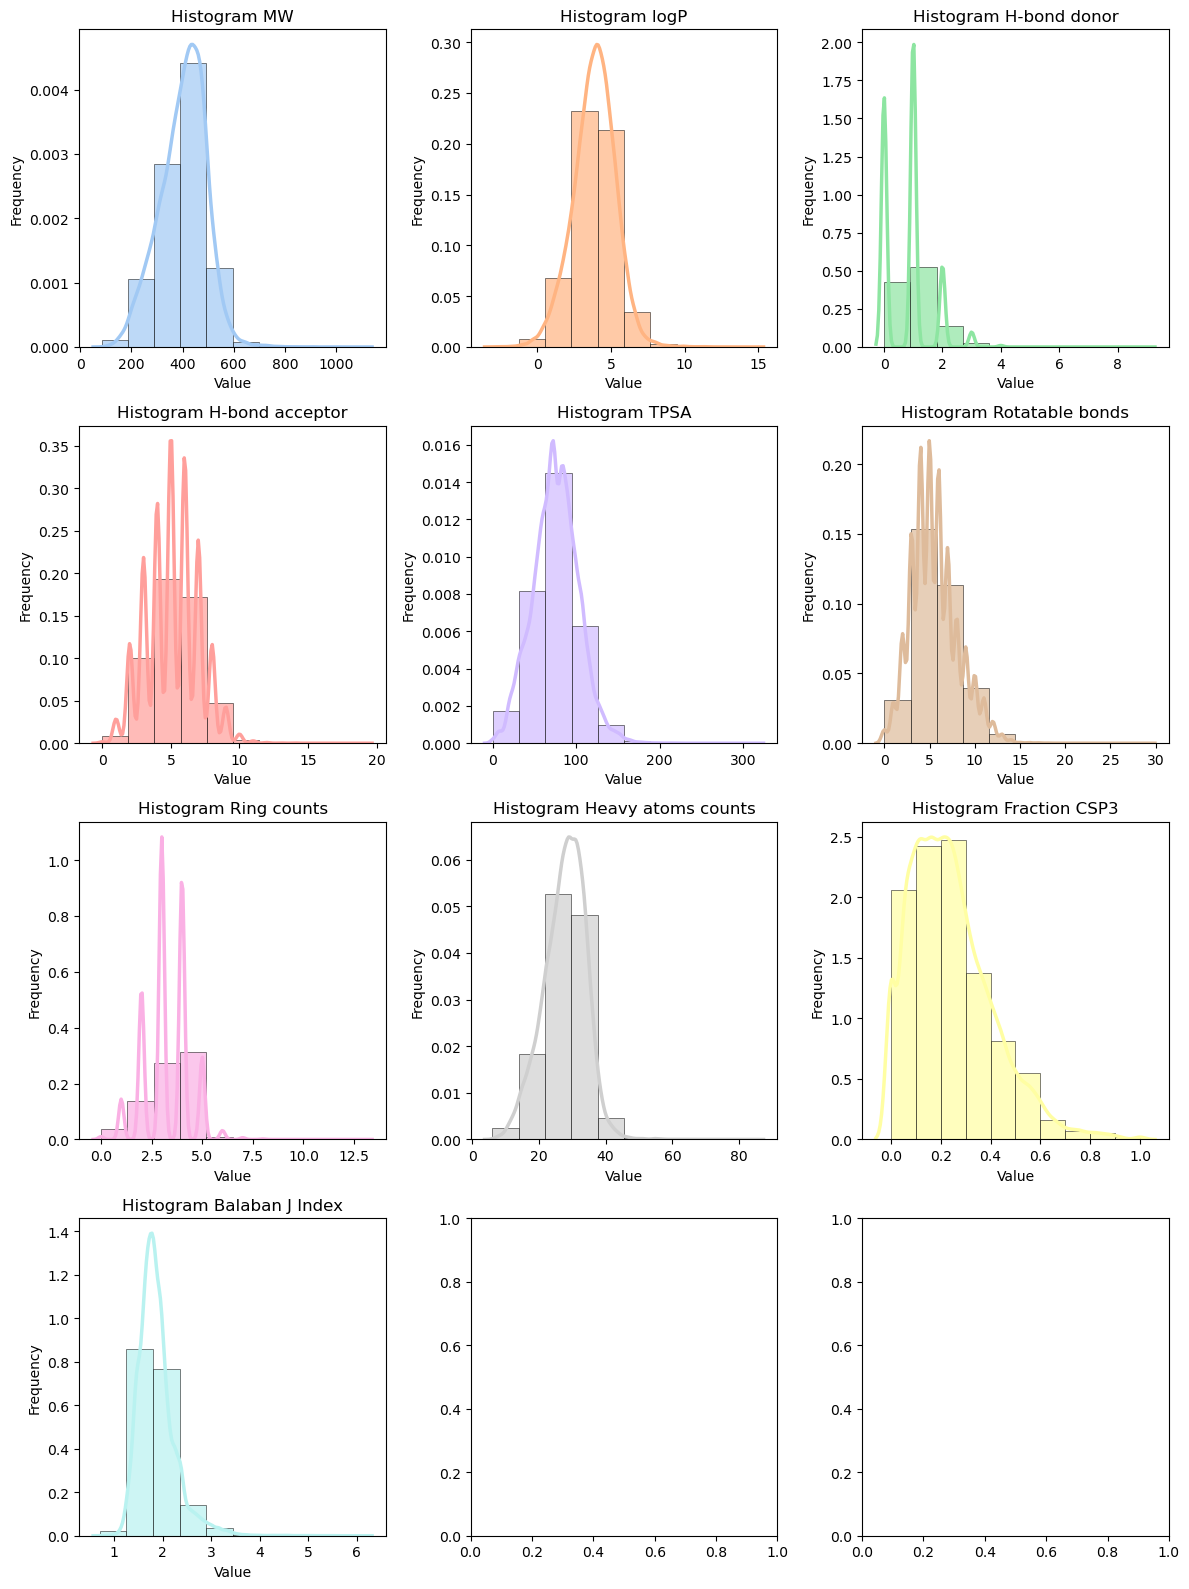

In [11]:
#import pandas as pd
#import matplotlib.pyplot as plt
#import seaborn as sns

col_num = df_chemdiv.select_dtypes(include='number').columns

num_columns = len(col_num)
num_rows = (num_columns + 2) // 3  

fig, axs = plt.subplots(num_rows, 3, figsize=(12, 4 * num_rows))

colors = sns.color_palette('pastel', n_colors=num_columns)

for i, column in enumerate(col_num):
    row = i // 3
    column_subplot = i % 3
    axs[row, column_subplot].hist(df_chemdiv[column], bins=10, density=True, alpha=0.7, edgecolor='black', linewidth=0.5, color=colors[i])
    sns.kdeplot(df_chemdiv[column], ax=axs[row, column_subplot], color=colors[i], linewidth=2.5)
    axs[row, column_subplot].set_xlabel('Value')
    axs[row, column_subplot].set_ylabel('Frequency')
    axs[row, column_subplot].set_title(f'Histogram {column}')


plt.tight_layout()
plt.savefig("/Users/carlafeliu/Docs/Master/TFM/github/TFM/output/histogram_chemdiv1.png")

plt.show()


In [34]:
#import pandas as pd

df_chemdiv_fin.to_csv("/Users/carlafeliu/Docs/Master/TFM/github/TFM/data/df_chemdiv_cys.csv", index=False)

We have a file with 39,301 targets, each accompanied by their SMILES and respective features. We don't have the pIC50 activity since that is what we aim to predict using Machine Learning.

We added 200 molecules selected randomly from the dataframe used to train the model.

In [12]:
#import pandas as pd
#import random
#from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

train_df = pd.read_csv("/Users/carlafeliu/Docs/Master/TFM/github/TFM/code/data_chemprop/chemprop_train_nonorm.csv")


random_mols_train = random.sample(range(len(train_df)), 200)
train_mols_df = train_df.iloc[random_mols_train].reset_index(drop=True)
train_mols_df.rename(columns={'Smiles': 'SMILES'}, inplace=True)
print(train_mols_df)

train_mols_df.to_csv("/Users/carlafeliu/Docs/Master/TFM/github/TFM/data/200mols_to_train.csv", index=False)



                                                SMILES       MW     logP  \
0    CC(C)[C@H](NC(=O)c1cc2cc(F)ccc2[nH]1)C(=O)N[C@...  709.844  4.26930   
1    COc1cc2c(cc1OC)S(=O)(=O)OC(C(=O)N[C@H](C=O)Cc1...  419.455  1.26020   
2    O=C(CF)CNC(=O)[C@H](Cc1ccccc1)NC(=O)c1cnnc2ccc...  346.290  3.39180   
3    CC(C)C[C@H](NC(=O)[C@H](C)NC(=O)OC(C)(C)C)C(=O...  479.521  1.86030   
4    CCC(NC(=O)C(CC(C)C)NC(=O)OCc1ccccc1)C(=O)C(=O)...  603.716  4.22020   
..                                                 ...      ...      ...   
195  CCC(C(=O)NC(CC(=O)O)C(=O)CN1CCCC1)n1cccc(NC(=O...  532.597  2.82930   
196  COC[C@@H]1CCCN1S(=O)(=O)c1ccc2c(c1)C(=O)C(=O)N...  374.400  4.19610   
197  CC(C)(F)C[C@H](N[C@@H](c1ccc(-c2ccc(C3(C(N)=O)...  557.638  5.22578   
198  CC[C@@H]1OCC(=O)[C@H]1NC(=O)[C@H](CC1(C)CCCC1)...  527.687  3.54810   
199  Cc1ccc(NC(=O)c2ccccc2)c(=O)n1CC(=O)N[C@@H](CC(...  527.533  2.86140   

     H-bond donor  H-bond acceptor  Rotatable bonds    TPSA  Ring counts  \
0          

In [13]:
df_to_predict = pd.concat([df_chemdiv_fin, train_mols_df], ignore_index=True)
df_to_predict = df_to_predict.drop('pchembl_value', axis = 1)

In [14]:
print(df_to_predict.head(20))

                                               SMILES          MW     logP  \
0                                C(#Cc1cccs1)c1ccccc1  184.034671   3.1479   
1             c1ccc(C2=NC(c3ccccc3)N3C2C3c2ccccc2)cc1  310.146999   4.6136   
2   C(#Cc1ccc(C2Nc3ccccc3C(c3ccccc3)(c3ccccc3)O2)o...  453.172879   7.1122   
3                          C(#Cc1csc2ccccc12)c1ccccc1  234.050321   4.3011   
4   C(#Cc1cccc(-c2nc3ccccc3nc2-c2cccc(C#Cc3ccc(Sc4...  698.185041  12.0658   
5   C(#Cc1cccc(-c2nc3ccccc3nc2-c2cccc(C#Cc3ccc(Oc4...  666.230728  11.3480   
6                               C(#Cc1ccccc1)c1ccccc1  178.078250   3.0864   
7             C(#Cc1cc(C#Cc2ccccc2)c2nonc2c1)c1ccccc1  320.094963   4.0224   
8                  C(#Cc1ccc2c(c1)sc1ccccc12)c1ccccc1  284.065971   5.4543   
9               C(#Cc1ccc2noc(-c3ccccc3)c2c1)c1ccccc1  295.099714   4.8946   
10  C(#Cc1cccc(-c2nc(-c3ccccc3)c(-c3ccccc3)[nH]2)c...  396.162649   6.8105   
11  C(#Cc1ccc(-c2nc(-c3ccc(Sc4ccccc4)cc3)c(-c3cccc...  504.16602

In [38]:
#Save the dataframe with the 200 molecules with activity known

#import pandas as pd

df_to_predict.to_csv("/Users/carlafeliu/Docs/Master/TFM/github/TFM/data/df_chemdiv_cys_withmols.csv", index=False)

Since we want to perform the prediction with train 4, which has been normalized using MinMaxScaler, we will apply the same normalization to our data.

In [15]:
#Normalization

#from sklearn.preprocessing import MinMaxScaler

smiles_column = df_to_predict['SMILES']

df_to_predict_norm = df_to_predict.drop(columns=['SMILES']).copy()

scaler = MinMaxScaler()

df_to_predict_norm[df_to_predict_norm.columns] = scaler.fit_transform(df_to_predict_norm)

df_to_predict_norm.insert(0, 'SMILES', smiles_column)

print(df_to_predict_norm)


                                                  SMILES        MW      logP  \
0                                   C(#Cc1cccs1)c1ccccc1  0.098477  0.346772   
1                c1ccc(C2=NC(c3ccccc3)N3C2C3c2ccccc2)cc1  0.221486  0.428765   
2      C(#Cc1ccc(C2Nc3ccccc3C(c3ccccc3)(c3ccccc3)O2)o...  0.360993  0.568539   
3                             C(#Cc1csc2ccccc12)c1ccccc1  0.147262  0.411283   
4      C(#Cc1cccc(-c2nc3ccccc3nc2-c2cccc(C#Cc3ccc(Sc4...  0.599976  0.845648   
...                                                  ...       ...       ...   
39496  CCC(C(=O)NC(CC(=O)O)C(=O)CN1CCCC1)n1cccc(NC(=O...  0.438463  0.328949   
39497  COC[C@@H]1CCCN1S(=O)(=O)c1ccc2c(c1)C(=O)C(=O)N...  0.284158  0.405409   
39498  CC(C)(F)C[C@H](N[C@@H](c1ccc(-c2ccc(C3(C(N)=O)...  0.462888  0.463011   
39499  CC[C@@H]1OCC(=O)[C@H]1NC(=O)[C@H](CC1(C)CCCC1)...  0.433674  0.369160   
39500  Cc1ccc(NC(=O)c2ccccc2)c(=O)n1CC(=O)N[C@@H](CC(...  0.433523  0.330745   

       H-bond donor  H-bond acceptor   

In [45]:

df_to_predict_norm.to_csv("/Users/carlafeliu/Docs/Master/TFM/github/TFM/data/df_chemdiv_cys_withmols_norm.csv", index=False)

**DATA ANALYSIS**

In [16]:
df_to_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39501 entries, 0 to 39500
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SMILES              39501 non-null  object 
 1   MW                  39501 non-null  float64
 2   logP                39501 non-null  float64
 3   H-bond donor        39501 non-null  float64
 4   H-bond acceptor     39501 non-null  float64
 5   TPSA                39501 non-null  float64
 6   Rotatable bonds     39501 non-null  float64
 7   Ring counts         39501 non-null  float64
 8   Heavy atoms counts  39501 non-null  float64
 9   Fraction CSP3       39501 non-null  float64
 10  Balaban J Index     39501 non-null  float64
dtypes: float64(10), object(1)
memory usage: 3.3+ MB


We examine the data distribution and observe that there is hardly any difference compared to before adding the 200 molecules.

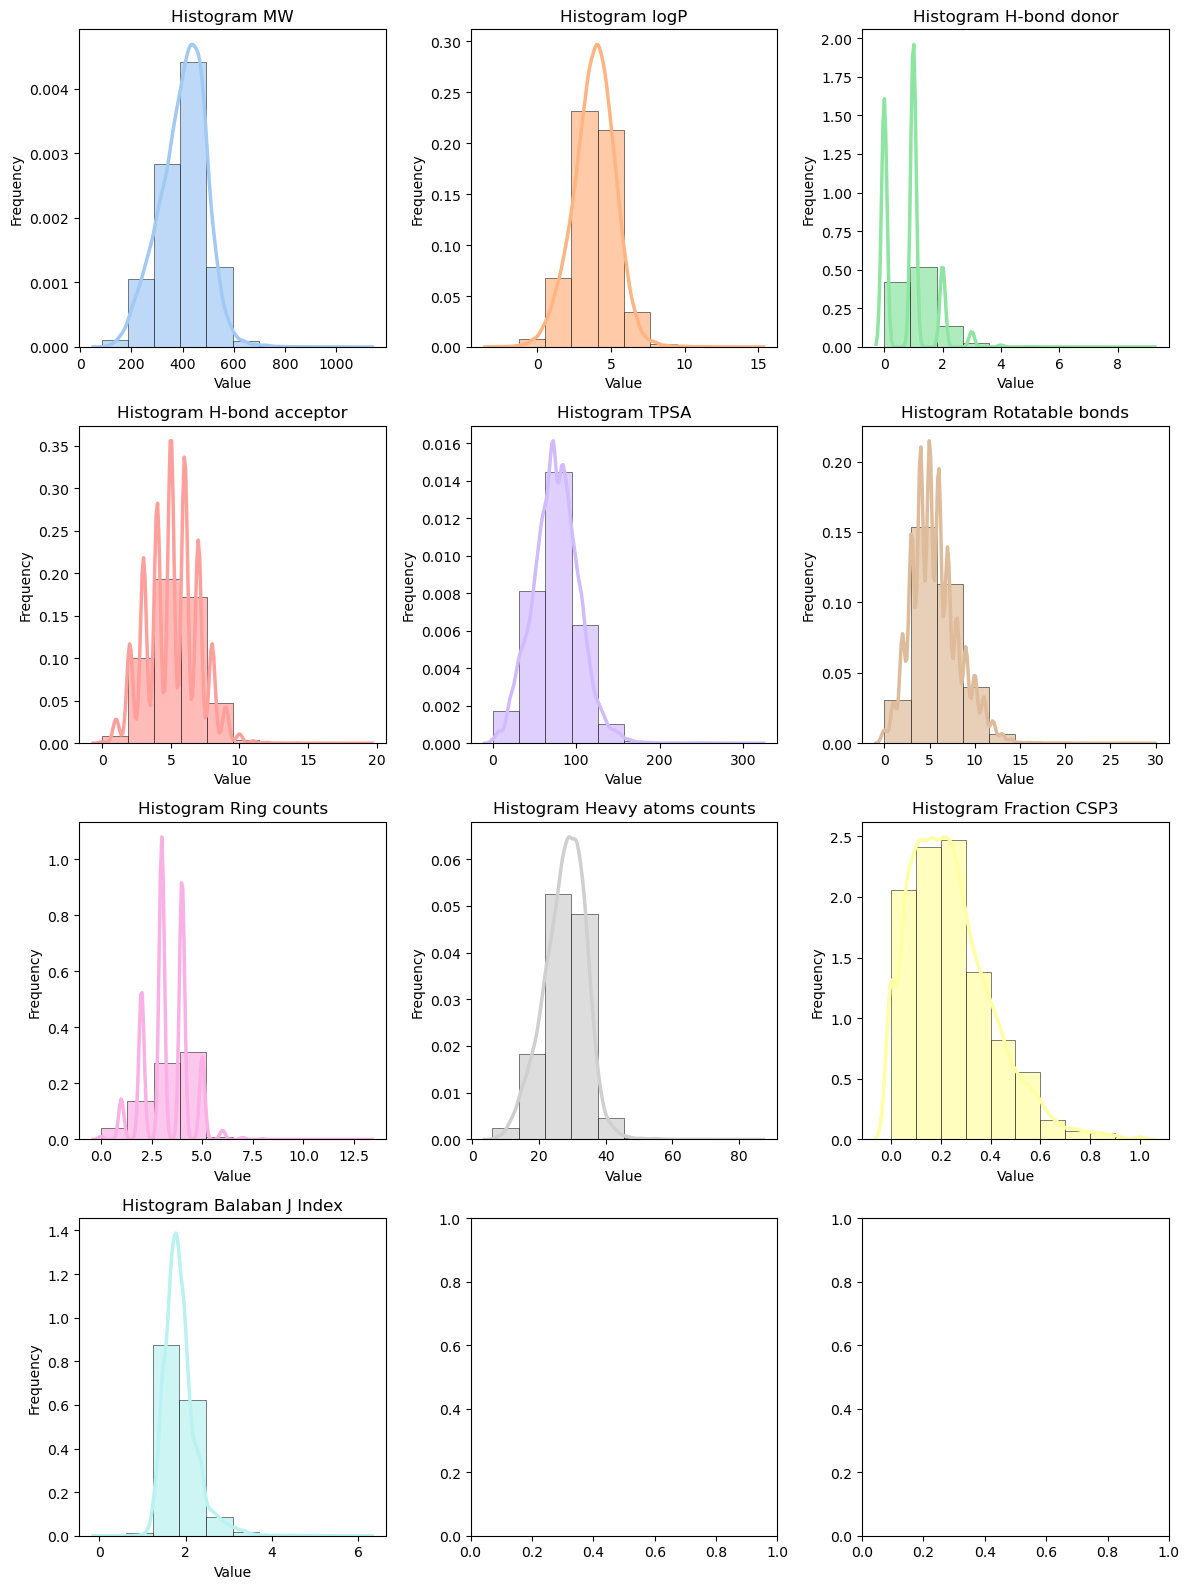

In [17]:
#import pandas as pd
#import matplotlib.pyplot as plt
#import seaborn as sns

# Obtener las columnas numéricas del dataframe
cols_num = df_to_predict.select_dtypes(include='number').columns

# Calcular el número de filas y columnas necesarias para los subplots
num_columns = len(cols_num)
num_rows = (num_columns + 2) // 3  # División entera redondeada hacia arriba, 3 histogramas por fila

# Crear los subplots con las dimensiones adecuadas
fig, axs = plt.subplots(num_rows, 3, figsize=(12, 4 * num_rows))

# Crear una paleta de colores pastel
colors = sns.color_palette('pastel', n_colors=num_columns)

# Crear un histograma y trazar la curva de densidad para cada columna numérica en el subplote correspondiente
for i, column in enumerate(cols_num):
    row = i // 3
    column_subplot = i % 3
    axs[row, column_subplot].hist(df_to_predict[column], bins=10, density=True, alpha=0.7, edgecolor='black', linewidth=0.5, color=colors[i])
    sns.kdeplot(df_to_predict[column], ax=axs[row, column_subplot], color=colors[i], linewidth=2.5)
    axs[row, column_subplot].set_xlabel('Value')
    axs[row, column_subplot].set_ylabel('Frequency')
    axs[row, column_subplot].set_title(f'Histogram {column}')

# Ajustar los espacios entre subplots
plt.tight_layout()
plt.savefig("/Users/carlafeliu/Docs/Master/TFM/github/TFM/output/histogram_chemdiv1.png")
# Mostrar el conjunto de subplots
plt.show()

Now, we analyze the correlation between variables.

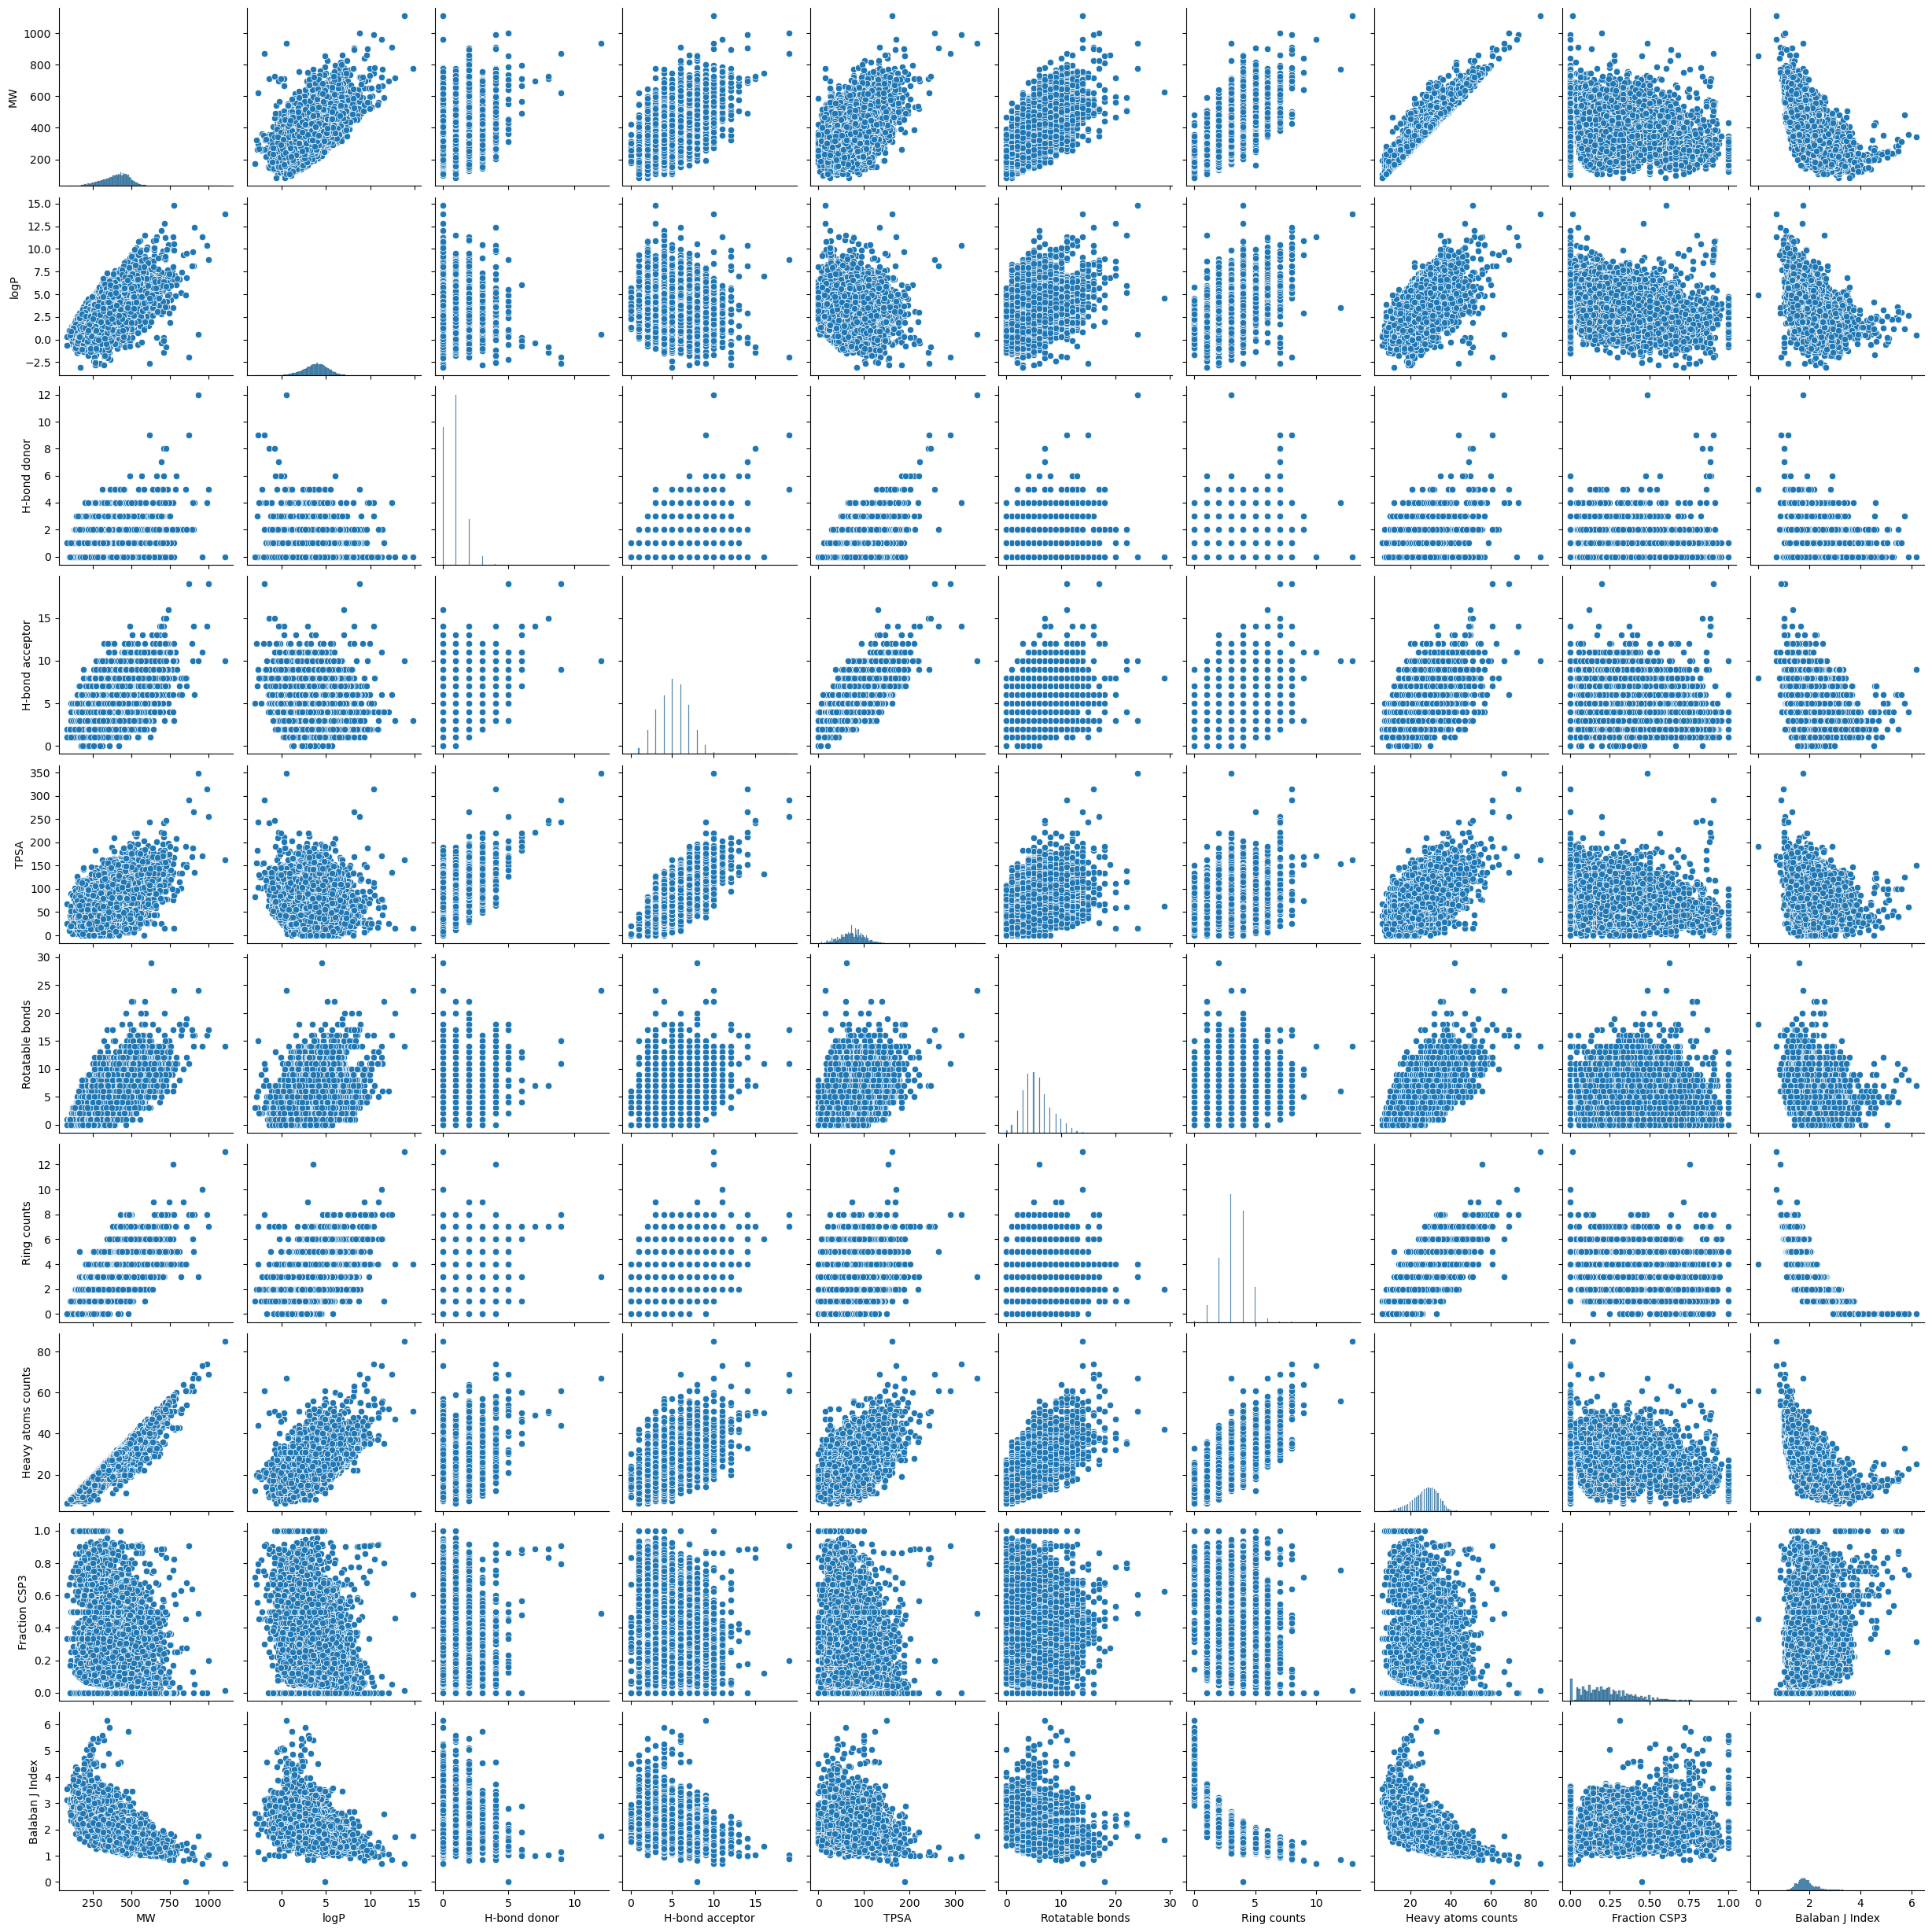

In [45]:
sns.pairplot(df_to_predict)
plt.show()

<Axes: >

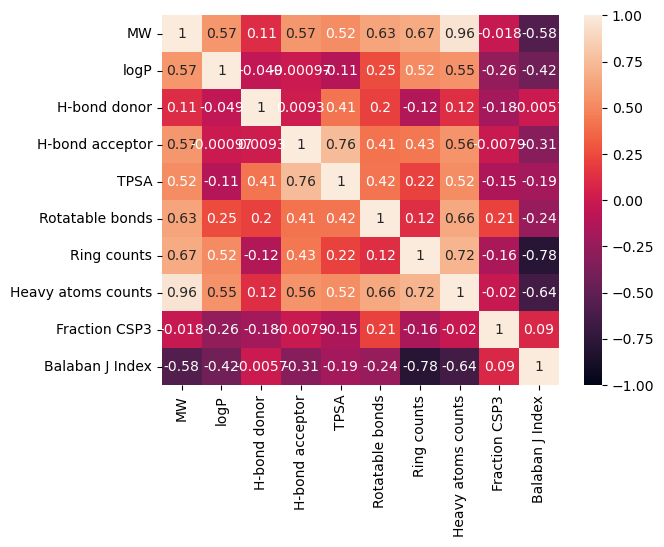

In [46]:
#import pandas as pd
#import seaborn as sns
#import matplotlib.pyplot as plt

sns.heatmap(dfnum.corr(), annot=True, vmin=-1, vmax=1)


## **2. DATABASE ZINC**

We downloaded the entire Zinc database from the 'tranches' section.:
https://zinc20.docking.org/tranches/home/

In [ ]:
#import os

os.chdir('/Users/carlafeliu/Docs/Master/TFM/data')

!wget -i /Users/carlafeliu/Docs/Master/TFM/github/TFM/data/ZINC-downloader-2D-smi.uri 


--2023-07-04 17:36:34--  http://files.docking.org/2D/AA/AAAA.smi
Resolving files.docking.org (files.docking.org)... 169.230.75.3
Connecting to files.docking.org (files.docking.org)|169.230.75.3|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86110 (84K) [application/smil+xml]
Saving to: 'AAAA.smi'

AAAA.smi            100%[===================>]  84.09K   242KB/s    in 0.3s    

2023-07-04 17:36:35 (242 KB/s) - 'AAAA.smi' saved [86110/86110]

--2023-07-04 17:36:35--  http://files.docking.org/2D/AA/AAAB.smi
Reusing existing connection to files.docking.org:80.
HTTP request sent, awaiting response... 200 OK
Length: 154083 (150K) [application/smil+xml]
Saving to: 'AAAB.smi'

AAAB.smi            100%[===================>] 150.47K   859KB/s    in 0.2s    

2023-07-04 17:36:35 (859 KB/s) - 'AAAB.smi' saved [154083/154083]

--2023-07-04 17:36:35--  http://files.docking.org/2D/AA/AAAC.smi
Reusing existing connection to files.docking.org:80.
HTTP request sent, awaiting re

We collected information from three of these files to conduct an analysis of a portion of the zinc data. 

In [19]:
#import pandas as pd
#import os

# Path to downloaded file .smi
path_smi = '/Users/carlafeliu/Docs/Master/TFM/data/'

files_smi = os.listdir(path_smi)

cont_download = 0

#group_smi = 3

list_df = []

for file in files_smi:
    if file.endswith('.smi'):
        path_file = os.path.join(path_smi, file)
        dfs_zinc = pd.read_csv(path_file, sep=' ', header=None, names=['SMILES','ZINC_ID'])
        
        list_df.append(dfs_zinc)

        cont_download += 1

        if cont_download == 3:
            break

# Create a dataframe
df_zinc1 = pd.concat(list_df)
df_zinc1 = df_zinc1.iloc[1:]


print(df_zinc1.head())
len(df_zinc1)




                                              SMILES    ZINC_ID
1   COc1ccc(O)c([C@H](C)NC(=O)C[C@@H](C)c2ccccc2F)c1  103528517
2            CN(Cc1ccccc1O)C(=O)c1cc(Cc2ccccc2)ccc1O  110223954
3  COc1ccc(O)c(CNC(=O)[C@@H]2C[C@@H]2c2ccc3ccccc3...  114543892
4                     O=C(NCc1ccccc1O)c1cc(Br)ccc1Cl  133782505
5      COc1ccc(O)c([C@@H](C)NC(=O)CCOc2cccc(Cl)c2)c1  157845687


88256

### 2.1. DATA ANALYSIS AND CLEANING

In [20]:
df_zinc1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88256 entries, 1 to 71
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   SMILES   88256 non-null  object
 1   ZINC_ID  88256 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB


In [21]:
df_zinc1.describe()

,SMILES,ZINC_ID
count,88256,88256
unique,88248,88255
top,Cc1cc(C(=O)N[C@H]2CC[C@H](CO)CC2)c(C)n1-c1ccc(...,zinc_id
freq,2,2


In [22]:
df_zinc1.shape

(88256, 2)

In [23]:
df_zinc1.isna().sum().sort_values()

SMILES     0
ZINC_ID    0
dtype: int64

In [24]:

dup_smiles_zinc1 = df_zinc1[df_zinc1['SMILES'].duplicated()]['SMILES'].unique()

if len(dup_smiles_zinc1) > 0:
    print("Duplicated SMILES:")
    for smile in dup_smiles_zinc1:
        print(smile)
else:
    print("No duplicated values were found.")

print(len(dup_smiles_zinc1))

Duplicated SMILES:
CC[C@H](N[C@H]1CCC[C@H]([S@@](=O)CC)C1)c1ccc(N(C)C)cc1
CC[C@H](N[C@@H]1CCC[C@H]([S@@](=O)CC)C1)c1ccc(N(C)C)cc1
CCN(C)c1ccc([C@H](C)N[C@@H]2CCC[C@H]([S@@](=O)CC)C2)cc1
CC[C@@H](N[C@@H]1CCC[C@H]([S@@](=O)CC)C1)c1ccc(N(C)C)cc1
CCN(C)c1ccc([C@@H](C)N[C@@H]2CCC[C@H]([S@@](=O)CC)C2)cc1
CC[C@@H](N[C@H]1CCC[C@H]([S@@](=O)CC)C1)c1ccc(N(C)C)cc1
Cc1cc(C(=O)N[C@H]2CC[C@H](CO)CC2)c(C)n1-c1ccc(F)cc1
smiles
8


In [25]:
#from rdkit import Chem

df_cleaned_zinc1 = df_zinc1.dropna(subset=['SMILES'], axis=0)

valid_smiles = [Chem.MolFromSmiles(smi) for smi in df_cleaned_zinc1['SMILES']]
valid_smiles = [smi for smi in valid_smiles if smi is not None]
print(len(valid_smiles))

df_zinc1 = df_cleaned_zinc1[df_cleaned_zinc1['SMILES'].isin([Chem.MolToSmiles(smi) for smi in valid_smiles])]

[21:44:39] SMILES Parse Error: syntax error while parsing: smiles
[21:44:39] SMILES Parse Error: Failed parsing SMILES 'smiles' for input: 'smiles'
[21:44:39] SMILES Parse Error: syntax error while parsing: smiles
[21:44:39] SMILES Parse Error: Failed parsing SMILES 'smiles' for input: 'smiles'


88254


In [28]:
print(df_zinc1.info())
print(df_zinc1.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87276 entries, 1 to 71
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   SMILES   87276 non-null  object
 1   ZINC_ID  87276 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB
None
                                              SMILES    ZINC_ID
1   COc1ccc(O)c([C@H](C)NC(=O)C[C@@H](C)c2ccccc2F)c1  103528517
2            CN(Cc1ccccc1O)C(=O)c1cc(Cc2ccccc2)ccc1O  110223954
3  COc1ccc(O)c(CNC(=O)[C@@H]2C[C@@H]2c2ccc3ccccc3...  114543892
4                     O=C(NCc1ccccc1O)c1cc(Br)ccc1Cl  133782505
5      COc1ccc(O)c([C@@H](C)NC(=O)CCOc2cccc(Cl)c2)c1  157845687


In [72]:

df_zinc1.to_csv('/Users/carlafeliu/Docs/Master/TFM/github/TFM/data/df_zincid_smile1.csv', index=False)

Construct the dataframe in order to use it in prediction module

In [29]:
#from rdkit import Chem
#from rdkit.Chem import Crippen, Descriptors


def calc_feat(df,columna):
    data_c = []
    for smile in df[columna]:
        if pd.notna(smile): 
            mol = Chem.MolFromSmiles(smile)
            if mol is not None:
                mw = Descriptors.MolWt(mol)
                logp = Descriptors.MolLogP(mol)
                hba_num = Descriptors.NumHAcceptors(mol)
                hbd_num = Descriptors.NumHDonors(mol)
                rotb_num = Descriptors.NumRotatableBonds(mol)
                tpsa = Chem.rdMolDescriptors.CalcTPSA(mol)
                ring_num = Chem.Descriptors.RingCount(mol)
                ha_num = Chem.Descriptors.HeavyAtomCount(mol)
                csp3 = Chem.Descriptors.FractionCSP3(mol)
                bji = Chem.Descriptors.BalabanJ(mol)

                data_c.append([mw,logp,hbd_num,hba_num,rotb_num,tpsa,ring_num,ha_num,csp3,bji])
    return data_c


data_c = calc_feat(df_zinc1, 'SMILES')
data_c

df_result_zinc1= pd.DataFrame(data_c,columns=['MW','logP',"H-bond donor","H-bond acceptor","Rotatable bonds", "TPSA", "Ring counts", "Heavy atoms counts", "Fraction CSP3", "Balaban J Index"])


In [32]:
df_zinc1 = df_zinc1.reset_index(drop=True)
df_result_zinc1 = df_result_zinc1.reset_index(drop=True)
df_result_zinc1.insert(0,'Smiles',df_zinc1['SMILES'])



In [33]:
print(df_result_zinc1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87276 entries, 0 to 87275
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Smiles              87276 non-null  object 
 1   MW                  87276 non-null  float64
 2   logP                87276 non-null  float64
 3   H-bond donor        87276 non-null  int64  
 4   H-bond acceptor     87276 non-null  int64  
 5   Rotatable bonds     87276 non-null  int64  
 6   TPSA                87276 non-null  float64
 7   Ring counts         87276 non-null  int64  
 8   Heavy atoms counts  87276 non-null  int64  
 9   Fraction CSP3       87276 non-null  float64
 10  Balaban J Index     87276 non-null  float64
dtypes: float64(5), int64(5), object(1)
memory usage: 7.3+ MB
None


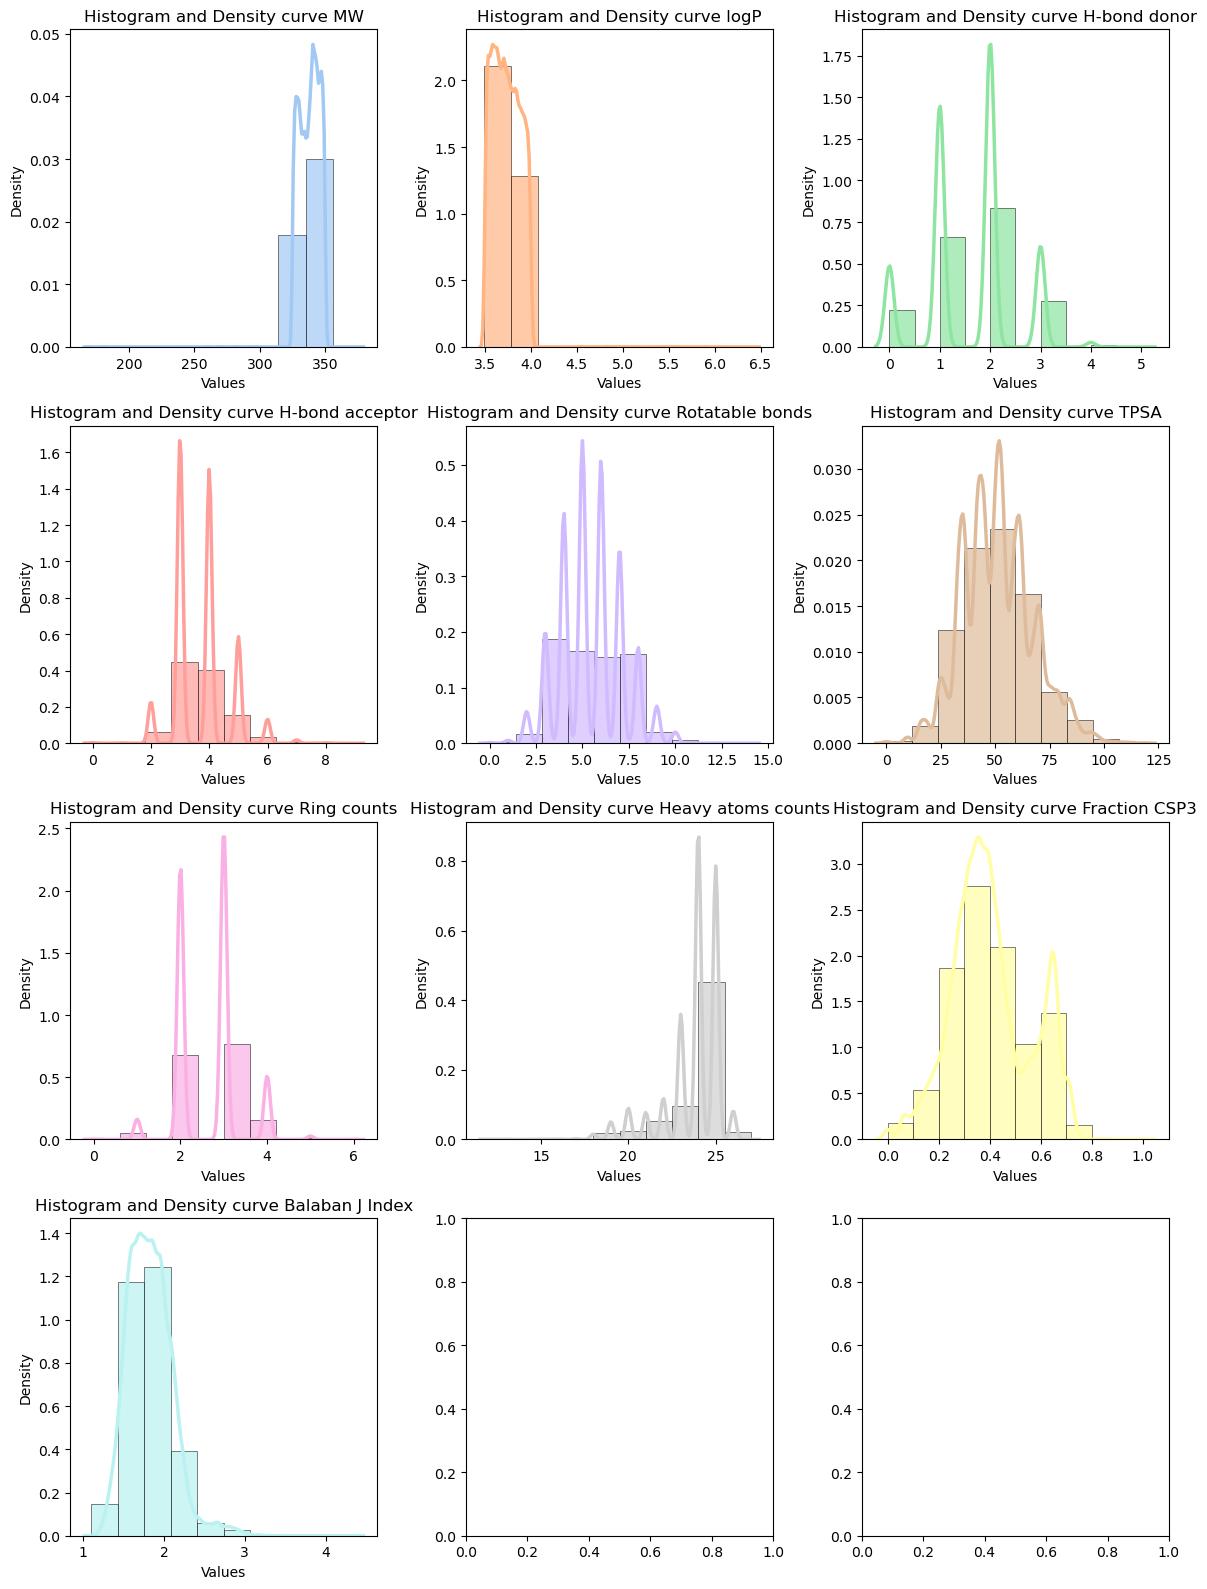

In [36]:
#import pandas as pd
#import matplotlib.pyplot as plt
#import seaborn as sns

col_num = df_result_zinc1.select_dtypes(include='number').columns

num_columns = len(col_num)
num_rows = (num_columns + 2) // 3  # División entera redondeada hacia arriba, 3 histogramas por fila

fig, axs = plt.subplots(num_rows, 3, figsize=(12, 4 * num_rows))

colors = sns.color_palette('pastel', n_colors=num_columns)

for i, column in enumerate(col_num):
    row = i // 3
    column_subplot = i % 3
    axs[row, column_subplot].hist(df_result_zinc1[column], bins=10, density=True, alpha=0.7, edgecolor='black', linewidth=0.5, color=colors[i])
    sns.kdeplot(df_result_zinc1[column], ax=axs[row, column_subplot], color=colors[i], linewidth=2.5)
    axs[row, column_subplot].set_xlabel('Values')
    axs[row, column_subplot].set_ylabel('Density')
    axs[row, column_subplot].set_title(f'Histogram and Density curve {column}')


plt.tight_layout()

plt.show()

In [37]:
df_result_zinc1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87276 entries, 0 to 87275
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Smiles              87276 non-null  object 
 1   MW                  87276 non-null  float64
 2   logP                87276 non-null  float64
 3   H-bond donor        87276 non-null  int64  
 4   H-bond acceptor     87276 non-null  int64  
 5   Rotatable bonds     87276 non-null  int64  
 6   TPSA                87276 non-null  float64
 7   Ring counts         87276 non-null  int64  
 8   Heavy atoms counts  87276 non-null  int64  
 9   Fraction CSP3       87276 non-null  float64
 10  Balaban J Index     87276 non-null  float64
dtypes: float64(5), int64(5), object(1)
memory usage: 7.3+ MB


In [38]:
df_result_zinc1.isna().sum().sort_values()

Smiles                0
MW                    0
logP                  0
H-bond donor          0
H-bond acceptor       0
Rotatable bonds       0
TPSA                  0
Ring counts           0
Heavy atoms counts    0
Fraction CSP3         0
Balaban J Index       0
dtype: int64

In [39]:
df_result_zinc1.describe()

,MW,logP,H-bond donor,H-bond acceptor,Rotatable bonds,TPSA,Ring counts,Heavy atoms counts,Fraction CSP3,Balaban J Index
count,87276.000000,87276.000000,87276.000000,87276.000000,87276.000000,87276.000000,87276.000000,87276.000000,87276.000000,87276.000000
mean,337.757019,3.736858,1.599271,3.701923,5.463919,51.274975,2.636991,23.747113,0.401969,1.826893
std,8.168243,0.152928,0.880177,0.931357,1.655363,15.861405,0.719632,1.569896,0.152712,0.278857
min,168.324000,3.492600,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,1.099118
25%,331.412000,3.611800,1.000000,3.000000,4.000000,41.490000,2.000000,23.000000,0.300000,1.623610
50%,338.451000,3.727860,2.000000,4.000000,5.000000,50.720000,3.000000,24.000000,0.380952,1.804460
75%,344.249000,3.854420,2.000000,4.000000,7.000000,61.360000,3.000000,25.000000,0.500000,1.993072
max,376.564000,6.438500,5.000000,9.000000,14.000000,118.540000,6.000000,27.000000,1.000000,4.383016


In [41]:
df_result_zinc1_cl = df_result_zinc1.dropna(subset=['Smiles'], axis=0)

valid_smiles = [Chem.MolFromSmiles(smi) for smi in df_result_zinc1_cl['Smiles']]
valid_smiles = [smi for smi in valid_smiles if smi is not None]

df_result_zinc1cl = df_result_zinc1_cl[df_result_zinc1_cl['Smiles'].isin([Chem.MolToSmiles(smi) for smi in valid_smiles])]
print(df_result_zinc1cl.head())
print(df_result_zinc1cl.info())

                                              Smiles       MW    logP  \
0   COc1ccc(O)c([C@H](C)NC(=O)C[C@@H](C)c2ccccc2F)c1  331.387  3.9109   
1            CN(Cc1ccccc1O)C(=O)c1cc(Cc2ccccc2)ccc1O  347.414  3.9608   
2  COc1ccc(O)c(CNC(=O)[C@@H]2C[C@@H]2c2ccc3ccccc3...  347.414  3.9739   
3                     O=C(NCc1ccccc1O)c1cc(Br)ccc1Cl  340.604  3.7381   
4      COc1ccc(O)c([C@@H](C)NC(=O)CCOc2cccc(Cl)c2)c1  349.814  3.7005   

   H-bond donor  H-bond acceptor  Rotatable bonds   TPSA  Ring counts  \
0             2                3                6  58.56            2   
1             2                3                5  60.77            3   
2             2                3                5  58.56            4   
3             2                2                3  49.33            2   
4             2                4                7  67.79            2   

   Heavy atoms counts  Fraction CSP3  Balaban J Index  
0                  24       0.315789         2.028179  
1         

In [29]:
#import pandas as pd

df_result_zinc1cl.to_csv("/Users/carlafeliu/Docs/Master/TFM/github/TFM/data/df_zinc1.csv", index=False)

As we did previously with the ChemDiv database, we added 200 molecules from the dataset used to train the model.

In [42]:
df_result_zinc1cl = df_result_zinc1cl.rename(columns={'Smiles':'SMILES'})

In [43]:

#import pandas as pd
#import random
#from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

train_mols_df = pd.read_csv("/Users/carlafeliu/Docs/Master/TFM/github/TFM/data/200mols_to_train.csv")

df_zinc1_add = pd.concat([df_result_zinc1cl, train_mols_df], ignore_index=True)
df_zinc1_add = df_zinc1_add.drop('pchembl_value', axis = 1)

print(df_zinc1_add.head())
print(df_zinc1_add.info())

                                              SMILES       MW    logP  \
0   COc1ccc(O)c([C@H](C)NC(=O)C[C@@H](C)c2ccccc2F)c1  331.387  3.9109   
1            CN(Cc1ccccc1O)C(=O)c1cc(Cc2ccccc2)ccc1O  347.414  3.9608   
2  COc1ccc(O)c(CNC(=O)[C@@H]2C[C@@H]2c2ccc3ccccc3...  347.414  3.9739   
3                     O=C(NCc1ccccc1O)c1cc(Br)ccc1Cl  340.604  3.7381   
4      COc1ccc(O)c([C@@H](C)NC(=O)CCOc2cccc(Cl)c2)c1  349.814  3.7005   

   H-bond donor  H-bond acceptor  Rotatable bonds   TPSA  Ring counts  \
0           2.0              3.0              6.0  58.56          2.0   
1           2.0              3.0              5.0  60.77          3.0   
2           2.0              3.0              5.0  58.56          4.0   
3           2.0              2.0              3.0  49.33          2.0   
4           2.0              4.0              7.0  67.79          2.0   

   Heavy atoms counts  Fraction CSP3  Balaban J Index  
0                24.0       0.315789         2.028179  
1         

In [46]:
#import pandas as pd

df_zinc1_add.to_csv("/Users/carlafeliu/Docs/Master/TFM/github/TFM/data/df_zinc1_add.csv", index=False)

MinMaxScaler Normalization:

In [44]:
#from sklearn.preprocessing import MinMaxScaler

smiles_column = df_zinc1_add['SMILES']

df_predict_zinc_norm = df_zinc1_add.drop(columns=['SMILES']).copy()

scaler = MinMaxScaler()

df_predict_zinc_norm[df_predict_zinc_norm.columns] = scaler.fit_transform(df_predict_zinc_norm)

df_predict_zinc_norm.insert(0, 'SMILES', smiles_column)

print(df_predict_zinc_norm.head())
print(df_predict_zinc_norm.info())

                                              SMILES        MW      logP  \
0   COc1ccc(O)c([C@H](C)NC(=O)C[C@@H](C)c2ccccc2F)c1  0.221648  0.538492   
1            CN(Cc1ccccc1O)C(=O)c1cc(Cc2ccccc2)ccc1O  0.243434  0.542500   
2  COc1ccc(O)c(CNC(=O)[C@@H]2C[C@@H]2c2ccc3ccccc3...  0.243434  0.543552   
3                     O=C(NCc1ccccc1O)c1cc(Br)ccc1Cl  0.234177  0.524613   
4      COc1ccc(O)c([C@@H](C)NC(=O)CCOc2cccc(Cl)c2)c1  0.246696  0.521593   

   H-bond donor  H-bond acceptor  Rotatable bonds      TPSA  Ring counts  \
0      0.222222         0.200000             0.30  0.215556        0.250   
1      0.222222         0.200000             0.25  0.223691        0.375   
2      0.222222         0.200000             0.25  0.215556        0.500   
3      0.222222         0.133333             0.15  0.181581        0.250   
4      0.222222         0.266667             0.35  0.249531        0.250   

   Heavy atoms counts  Fraction CSP3  Balaban J Index  
0            0.230769       0.

In [82]:
#import pandas as pd

df_predict_zinc_norm.to_csv("/Users/carlafeliu/Docs/Master/TFM/github/TFM/data/df_predict_zinc_norm.csv", index=False)